In [1]:
import numpy as np
from astropy import units as un
from psdenoiser import Denoiser, denoiser_csts

import matplotlib.pyplot as plt

/home/dbreitman/.conda/envs/pytorch_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


# Testing 21cmPSDenoiser
In this notebook, we will load the test database, run the denoiser, and compare with the database to make sure everything is running as expected.

In [2]:
with np.load("test_ps.npz", allow_pickle=True) as f:
    ps_realisations = f["deltasq_realisations"]*un.mK**2
    true_ps_means = f["true_deltasq_means"]*un.mK**2 # estimated from about 200 21cmFAST simulations with different ICs per PS sample
    nn_ps_means = f["nn_deltasq_means"]*un.mK**2 # pre-calculated 21cmPSDenoiser outputs
    redshifts = f["redshifts"]
    kperp = f["kperp_over_Mpc"]/un.Mpc
    kpar = f["kpar_over_Mpc"]/un.Mpc
sample_idx = 6638 # same as in the paper

If you have a GPU, you can actually run the denoiser in the next step. <br>
If you do not have a GPU, skip to the next cell where you can load a pre-computed output.

In [3]:
# Number 206 is the one used in Figure 4 in Breitman+25a
denoiser = Denoiser(nsamples=10)
mean_ps=denoiser.predict(ps_realisations[sample_idx], kperp, kpar)

Sampling :   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
# Run this if you don't have a GPU and want to make the plots in the next step
from psdenoiser import DenoiserOutput
mean_ps = DenoiserOutput(nn_ps_means[sample]*un.mK**2, # samples
                         nn_ps_means[sample]*un.mK**2, # median
                         np.zeros_like(nn_ps_means[sample].value)+np.nan*un.mK**2, # std (which I don't have)
                         kperp, kpar
                        )

Let's now reproduce the first row of Figure 4 in the paper:

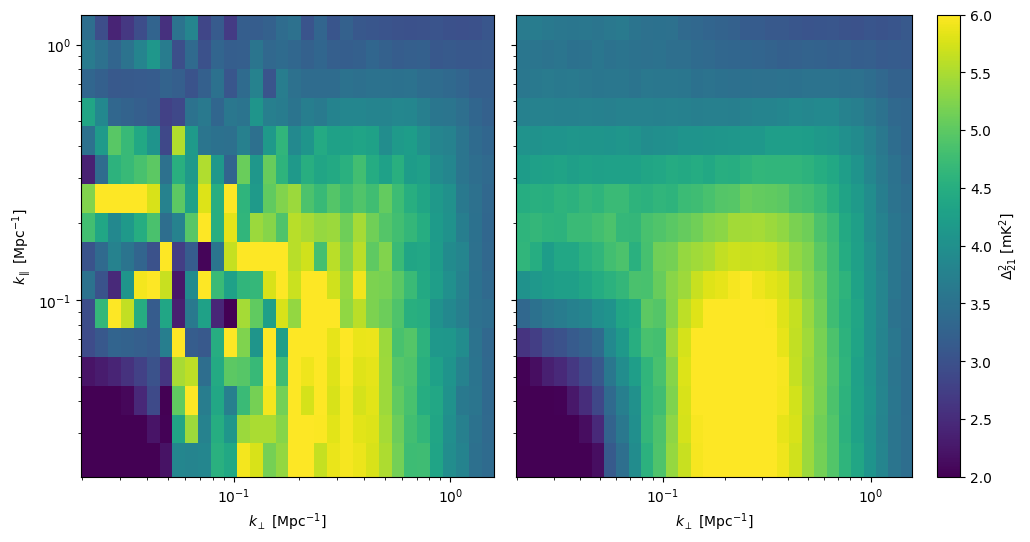

In [4]:
fig, axs = plt.subplots(1,2, figsize=(12,6), sharey=True, gridspec_kw={"width_ratios":[1,1.2], "wspace":0.05})
vmin = 2
vmax = 6
axs[0].pcolormesh(kperp.value, kpar.value, ps_realisations[sample_idx].T.value, vmin=vmin, vmax=vmax)
im=axs[1].pcolormesh(kperp.value, kpar.value, mean_ps.deltasq_median.T.value, vmin=vmin, vmax=vmax)
fig.colorbar(im, label = r"$\Delta^2_{21}$ [mK$^2$]")
axs[0].loglog()
axs[1].loglog()
axs[0].set_xlabel(r"$k_\perp$ [Mpc$^{-1}$]")
axs[1].set_xlabel(r"$k_\perp$ [Mpc$^{-1}$]")
axs[0].set_ylabel(r"$k_\parallel$ [Mpc$^{-1}$]")
plt.show()

Let's also reproduce the entire figure, but by calling the plotting function from plot.py:

In [5]:
from plot import results_fig4

HERA redshift 6.1 vs input redshift 6.1


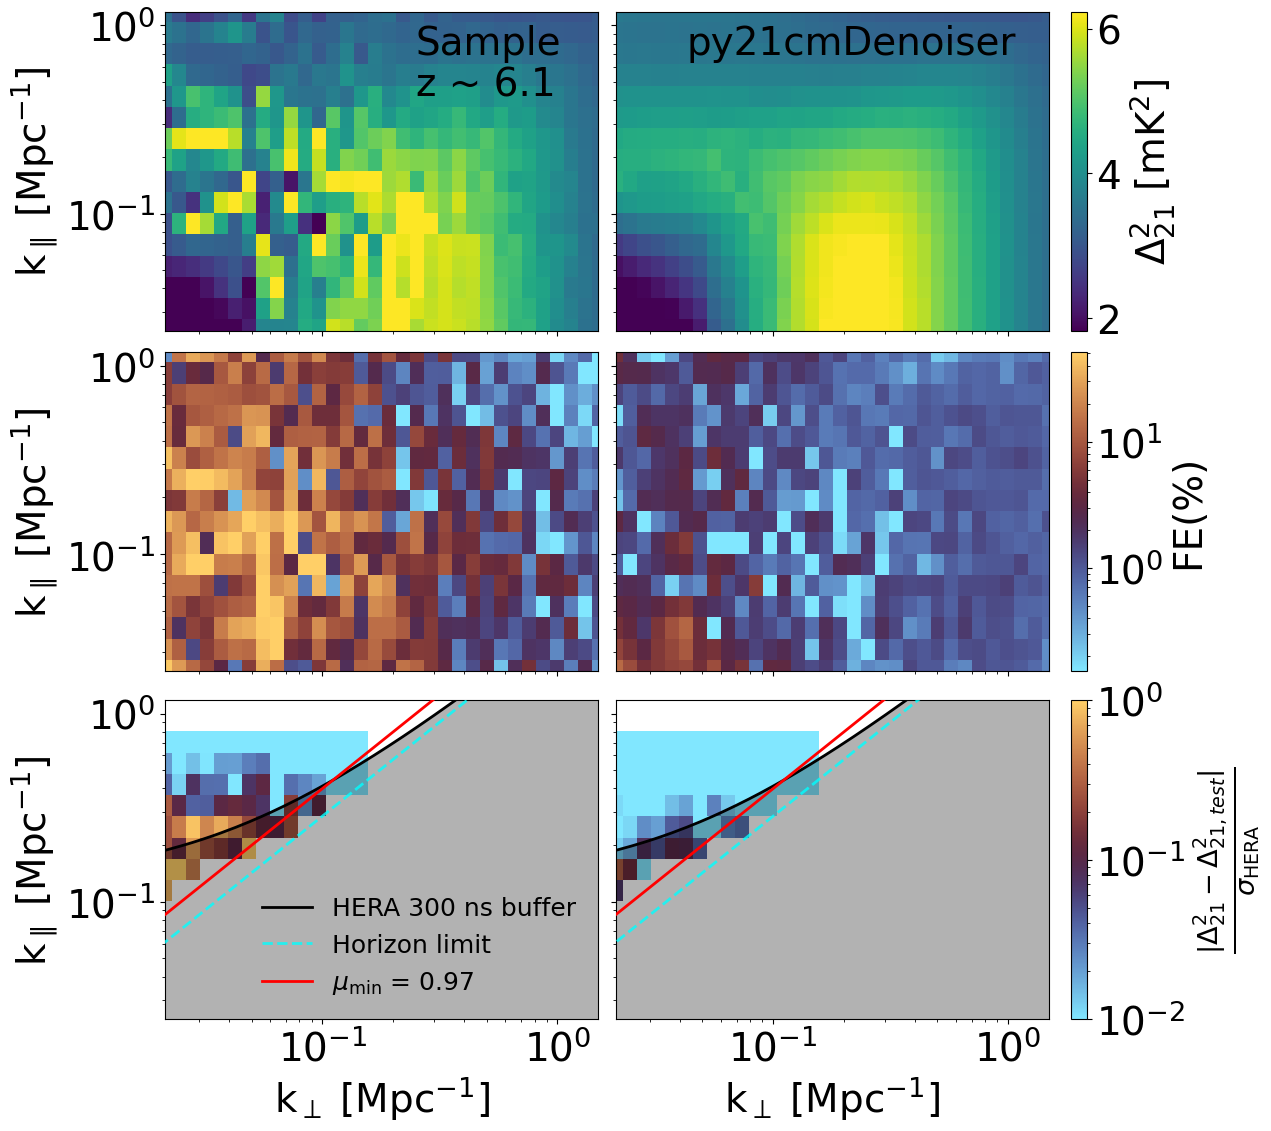

In [6]:
results_fig4(kperp.value,
             kpar.value,
             ps_realisations[sample_idx].value, 
             true_ps_means[sample_idx].value, 
             nn_ps_means[sample_idx].value, 
             redshifts[sample_idx], 
             cmap='managua_r', 
             cmap2='managua_r', 
             figsize=(12.6,11.2),
             fontsize=28)

Let's also reproduce Figure 5. For this one, we need many denoiser evaluations, so we will just use the ones pre-computed in the file to save time.

In [7]:
from plot import results_fig5

In [8]:
nn_fes = abs((nn_ps_means - true_ps_means)/true_ps_means)*100.
sample_fes = abs((ps_realisations - true_ps_means)/true_ps_means)*100.

There are 424 samples in the redshift range requested.


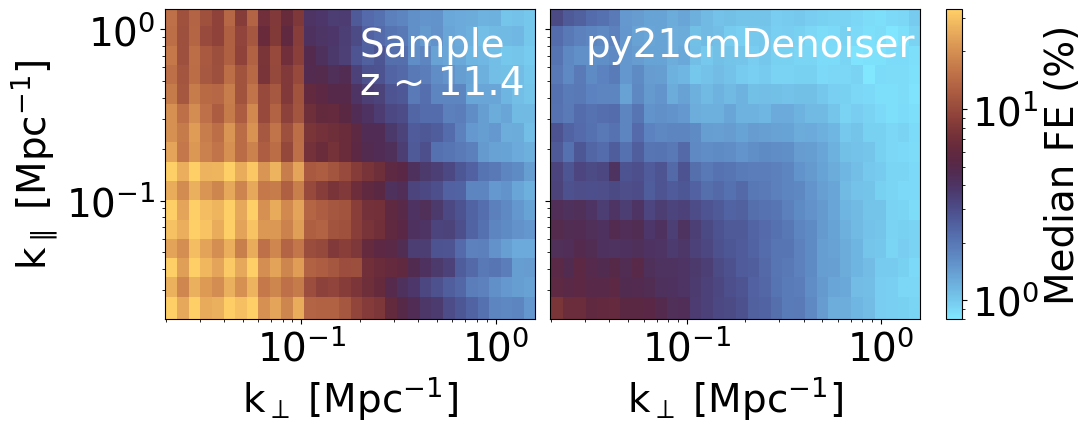

In [9]:
results_fig5(kperp.value, kpar.value,
                 nn_fes, 
                 sample_fes, 
                 redshifts, 
                 cmap = 'managua_r', 
                 z_range = [11.3, 11.5],
                 figsize=(10.8,4.2),
                 fontsize=28,
                 )